# Loading data / preprocessing

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as p
import os


# RUN_PATH = "/media/floricslimani/SSD4To/SSD_floricslimani/Fish_seq/Davide/2024-09-03 - SeqFISH_Run8 - HeLa_POLR2"
RUN_PATH = '/media/floricslimani/SSD4To/SSD_floricslimani/Fish_seq/Davide/2024-08-12 - SeqFISH - HeLa - Puro - R2TP1-2_Run7/'

OUTPUT_PATH = RUN_PATH + "/analysis/density/"
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [5]:
Acquisition = pd.read_feather(RUN_PATH + "/result_tables/Acquisition.feather")
Detection = pd.read_feather(RUN_PATH + "/result_tables/Detection.feather", columns= ['voxel_size'])
Drift = pd.read_feather(RUN_PATH + "/result_tables/Drift.feather")

VOXEL_SIZE = tuple(Detection['voxel_size'].iat[0])
VOXEL_SIZE = [int(i) for i in VOXEL_SIZE]


In [88]:
check_len = len(Drift)
if 'cycle' not in Drift.columns :
    Drift = pd.merge(
        Drift,
        Acquisition.loc[:,['acquisition_id', 'cycle']],
        on= 'acquisition_id'
    )
assert len(Drift) == check_len
Drift

,drift_id,acquisition_id,drift_type,drift_z,drift_y,drift_x,ref_bead_threshold,drift_bead_threshold,ref_bead_number,drift_bead_number,found_symetric_drift,voxel_size,bead_size,error,phasediff,location,cycle
0,0,0,fish,0,0,0,None,None,None,None,None,"[200, 97, 97]","[200, 200, 200]",NaN,NaN,Location-01,0
1,1,0,dapi,0,-1,-5,None,None,None,None,None,"[200, 97, 97]","[200, 200, 200]",1.0,3.688152e-17,Location-01,0
2,2,9,fish,0,-4,2,None,None,None,None,None,"[200, 97, 97]","[200, 200, 200]",1.0,2.258857e-18,Location-01,1
3,3,18,fish,0,-1,3,None,None,None,None,None,"[200, 97, 97]","[200, 200, 200]",1.0,-5.960114e-18,Location-01,2
4,4,27,fish,0,-4,3,None,None,None,None,None,"[200, 97, 97]","[200, 200, 200]",1.0,1.926573e-18,Location-01,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,130,89,fish,0,0,0,None,None,None,None,None,"[200, 97, 97]","[200, 200, 200]",1.0,-1.770736e-17,Location-10,9
131,131,98,fish,0,0,0,None,None,None,None,None,"[200, 97, 97]","[200, 200, 200]",1.0,-3.022967e-17,Location-10,10
132,132,107,fish,0,0,0,None,None,None,None,None,"[200, 97, 97]","[200, 200, 200]",1.0,-2.786768e-17,Location-10,11
133,133,116,fish,0,0,0,None,None,None,None,None,"[200, 97, 97]","[200, 200, 200]",1.0,-3.145040e-17,Location-10,12


# Statistics

## Correction sucess rate

### General

In [60]:
dapi_mask = (~Drift['error'].isna()) & (Drift['drift_type'] == 'dapi')
fish_mask = (~Drift['error'].isna()) & (Drift['drift_type'] == 'fish')

In [78]:
dapi_sucess = Drift.loc[dapi_mask & ((Drift["drift_z"] != 0) | (Drift["drift_y"] != 0) | (Drift["drift_x"] != 0))]

dapi_sucess_number = len(dapi_sucess)
dapi_test_number = len(Drift[dapi_mask])
dapi_fail_number = dapi_test_number - dapi_sucess_number

dapi_sucess_percentage = dapi_sucess_number*100/dapi_test_number
dapi_fail_percentage = dapi_fail_number*100/dapi_test_number

In [79]:
fish_sucess = Drift.loc[fish_mask & ((Drift["drift_z"] != 0) | (Drift["drift_y"] != 0) | (Drift["drift_x"] != 0))]

fish_sucess_number = len(fish_sucess)
fish_test_number = len(Drift[fish_mask])
fish_fail_number = fish_test_number - fish_sucess_number

fish_sucess_percentage = fish_sucess_number*100/fish_test_number
fish_fail_percentage = fish_fail_number*100/fish_test_number

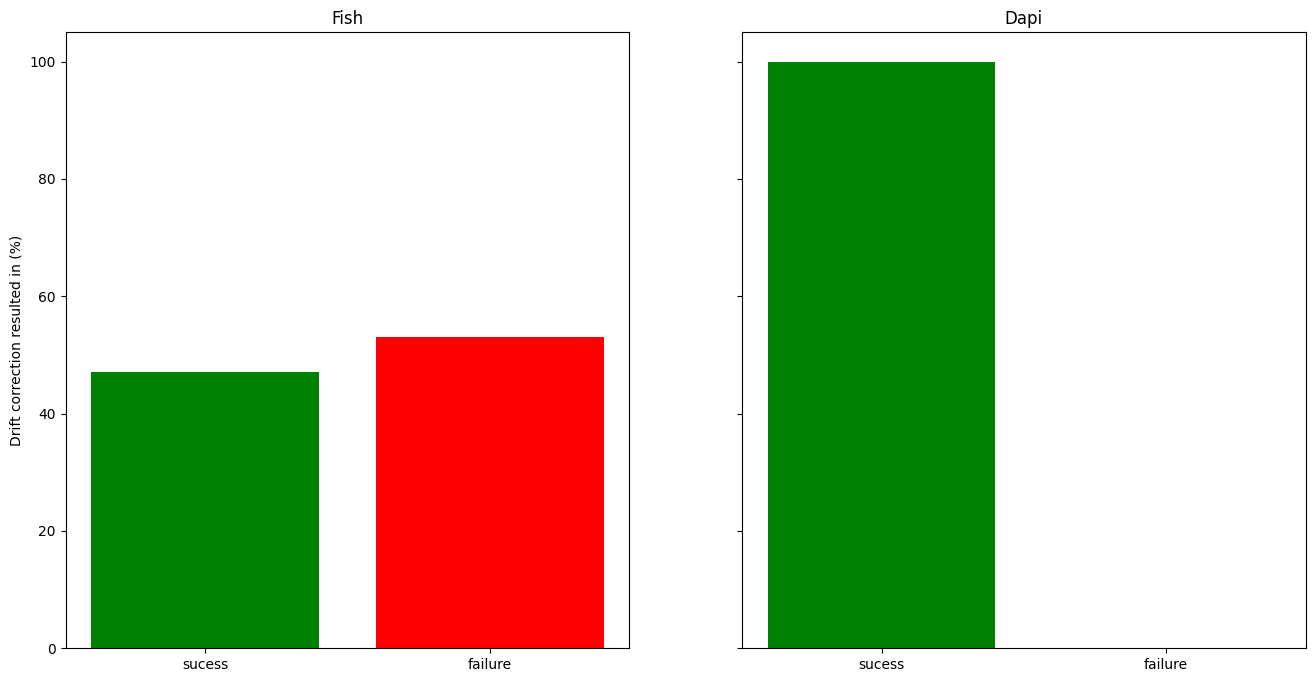

In [85]:
fig, axes = plt.subplots(1,2, figsize=(16,8), sharey=True)
axes : 'list[plt.Axes]'
fish, dapi = axes

fish.bar(['sucess', 'failure'], [fish_sucess_percentage, fish_fail_percentage], color=['green', 'red'])
dapi.bar(['sucess', 'failure'], [dapi_sucess_percentage, dapi_fail_percentage], color=['green', 'red'])

fish.set_title('Fish')
dapi.set_title('Dapi')
fish.set_ylabel("Drift correction resulted in (%)")

plt.show()

### Per cycle

In [106]:
Drift['sucess'] = (Drift['drift_z'] != 0) | (Drift['drift_y'] != 0) | (Drift['drift_x'] | 0)
per_cycle_sucess = Drift.loc[~Drift['error'].isna()].groupby(['drift_type','cycle']).agg({
    'sucess' : ['sum','count'],
})

per_cycle_sucess.columns = ['sucess', 'total']
per_cycle_sucess['sucess_percentage'] = per_cycle_sucess['sucess']*100/per_cycle_sucess['total']
per_cycle_sucess

sucess  total  sucess_percentage
drift_type cycle                                  
dapi       0           9      9         100.000000
fish       1           7      9          77.777778
           2           6      9          66.666667
           3           7      9          77.777778
           4           5      9          55.555556
           5           7      9          77.777778
           6           5      9          55.555556
           7           5      9          55.555556
           8           4      9          44.444444
           9           3      9          33.333333
           10          2      9          22.222222
           11          1      9          11.111111
           12          2      9          22.222222
           13          1      9          11.111111

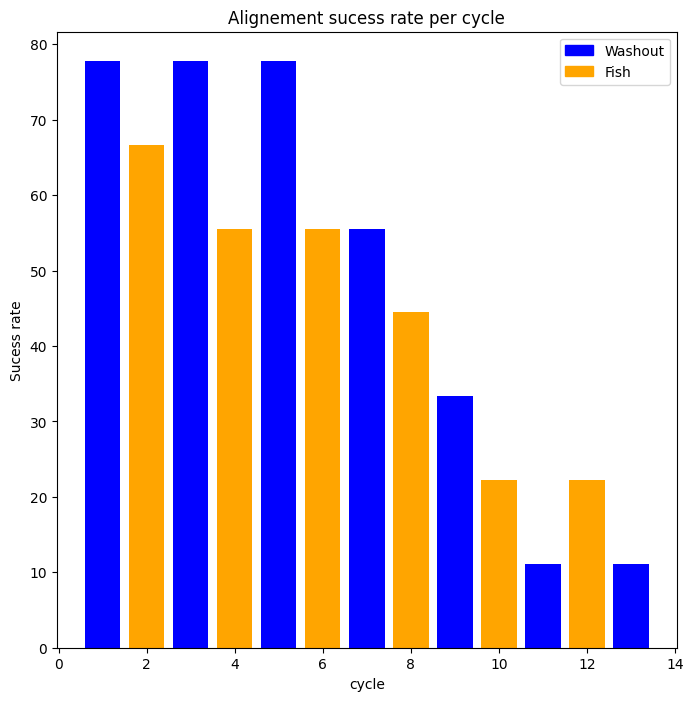

In [128]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()

X = per_cycle_sucess.loc['fish'].index
Y = per_cycle_sucess.loc['fish']['sucess_percentage']
color = ['blue','orange']
labels = ['fish', 'washout']

legend_symb = [p.Rectangle((0,0),0,1, color= 'blue'), p.Rectangle((0,0),0,1, color= 'orange')]
plt.legend(legend_symb,['Washout','Fish'])

ax.bar(X, Y, color=color)
ax.set_ylabel('Sucess rate')
ax.set_xlabel('cycle')
ax.set_title('Alignement sucess rate per cycle')

plt.show()

## Drift distance

In [151]:
def compute_euclidian_drift(df: pd.DataFrame, voxel_size) :
    df.loc[:,['drift_z', 'drift_y', 'drift_x']] *= voxel_size
    df_sq = df.apply(np.square).sum(axis=1)
    df['euclidian_drift'] = df_sq.apply(np.sqrt)
    return df

In [153]:
fish_drift = Drift[(~Drift['error'].isna()) & (Drift['drift_type'] == 'fish')].loc[:,['cycle','drift_z', 'drift_y', 'drift_x']]
fish_drift = compute_euclidian_drift(fish_drift, VOXEL_SIZE)
fish_drift


,cycle,drift_z,drift_y,drift_x,euclidian_drift
2,1,0,-388,194,433.798340
3,2,0,-97,291,306.747453
4,3,0,-388,291,485.009278
5,4,0,-97,291,306.767013
6,5,0,-485,291,565.624434
...,...,...,...,...,...
130,9,0,0,0,9.000000
131,10,0,0,0,10.000000
132,11,0,0,0,11.000000
133,12,0,0,0,12.000000


In [154]:
dapi_drift = Drift.loc[(~Drift['error'].isna()) & (Drift['drift_type'] == 'dapi')].loc[:,['cycle','drift_z', 'drift_y', 'drift_x']]
dapi_drift = compute_euclidian_drift(dapi_drift, VOXEL_SIZE)
dapi_drift

,cycle,drift_z,drift_y,drift_x,euclidian_drift
1,0,0,-97,-485,494.604893
16,0,0,-97,-485,494.604893
31,0,-600,0,-388,714.523618
46,0,400,0,-388,557.264749
61,0,800,0,-388,889.125413
76,0,-400,97,-388,565.643881
91,0,0,0,-388,388.000000
106,0,800,97,-388,894.400917
121,0,0,97,-388,399.941246


### Absolute drift distance

In [165]:
Z_score = 1.645 #90% confidence interval
T_score = 1.833 #90% confidence interval; n = 10

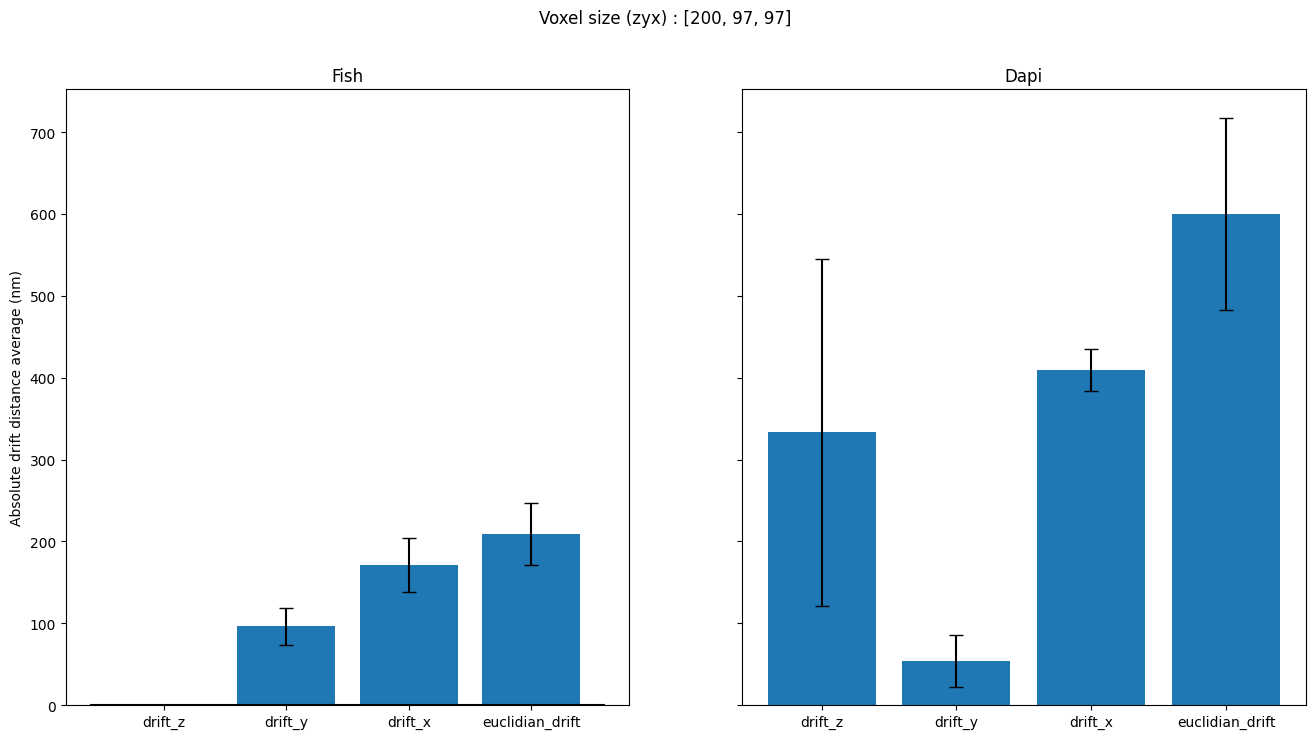

In [176]:
fig, axes = plt.subplots(1,2, figsize=(16,8), sharey=True)
fish, dapi = axes

fish_data = fish_drift.drop(columns='cycle')
dapi_data = dapi_drift.drop(columns='cycle')

fish_mean = fish_data.apply(np.abs).mean(axis=0)

fish_std = fish_data.apply(np.abs).std(axis=0)
fish_count = fish_data.count(axis=0)
confidence_interval = (T_score*fish_std) / fish_count.apply(np.sqrt)

fish.bar(fish_mean.index, fish_mean, yerr=confidence_interval, capsize=5)
xmin,xmax,ymin,ymax = fish.axis()
fish.plot([xmin,xmax], [0,0],'k')
fish.set_title('Fish')
fish.set_ylabel('Absolute drift distance average (nm)')

dapi_mean = dapi_data.apply(np.abs).mean(axis=0)
dapi_std = dapi_data.apply(np.abs).std(axis=0)
dapi_count = dapi_data.count(axis=0)
confidence_interval = (T_score*dapi_std) / dapi_count.apply(np.sqrt)

dapi.bar(dapi_mean.index, dapi_mean, yerr=confidence_interval, capsize=5)
xmin,xmax,ymin,ymax = dapi.axis()
dapi.set_title('Dapi')

fig.suptitle(f"Voxel size (zyx) : {VOXEL_SIZE}")

plt.show()

**Note** : Dapi z stack number is different than reference (fish cycle 0) z stack number

## Mean euclidian drift per cycle

In [189]:
fish_data = fish_drift.groupby('cycle').agg({
    'euclidian_drift' : ['mean', 'std', 'count']
})

fish_data[('euclidian_drift','confidence_interval')] = (T_score * fish_data.loc[:,("euclidian_drift",'std')]) / fish_data.loc[:,("euclidian_drift",'count')].apply(np.sqrt)
fish_data


euclidian_drift                                      
                 mean         std count confidence_interval
cycle                                                      
1          284.635074  169.769282     9          103.729031
2          183.451651  140.617578     9           85.917340
3          332.307055  198.141424     9          121.064410
4          175.232208  163.192777     9           99.710786
5          390.089252  223.492276     9          136.553781
6          244.848572  229.260930     9          140.078428
7          313.916619  292.585716     9          178.769872
8          227.381223  260.292868     9          159.038942
9          187.877902  268.537951     9          164.076688
10         117.712439  213.735244     9          130.592234
11          72.634365  184.903096     9          112.975792
12         119.277876  212.872936     9          130.065364
13          69.613636  169.840909     9          103.772795

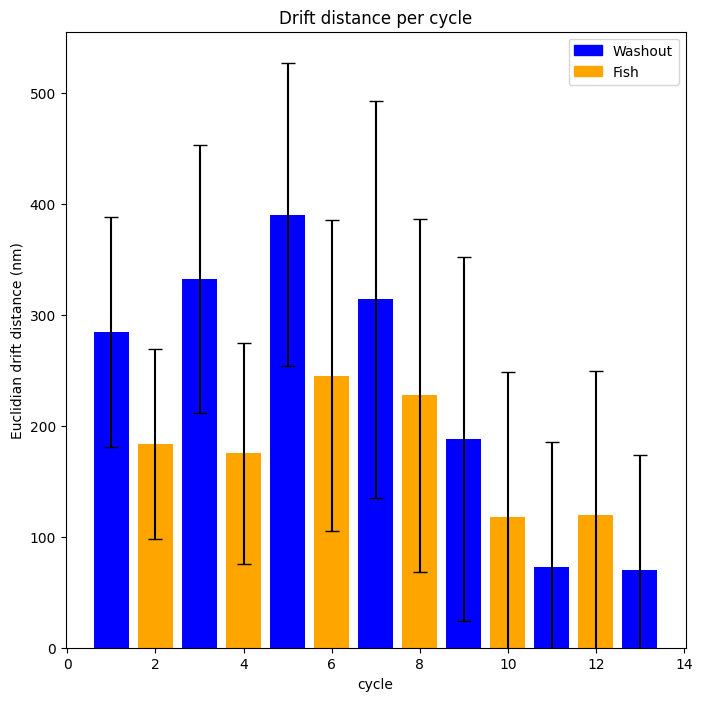

In [198]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()

X = fish_data.index
Y = fish_data.loc[:,('euclidian_drift','mean')]
error_bar = fish_data.loc[:,('euclidian_drift','confidence_interval')]
color = ['blue','orange']
labels = ['fish', 'washout']

legend_symb = [p.Rectangle((0,0),0,1, color= 'blue'), p.Rectangle((0,0),0,1, color= 'orange')]
plt.legend(legend_symb,['Washout','Fish'])

ax.bar(X, Y, color=color, yerr = error_bar, capsize=5)
ax.set_ylabel('Euclidian drift distance (nm)')
ax.set_xlabel('cycle')
ax.set_title('Drift distance per cycle')

xmin,xmax,ymin,ymax = plt.axis()

ax.set_ylim(0,ymax)

plt.show()